# Predicting Sex Assigned at Birth with Regression

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
from collections import OrderedDict
import torch
torch.manual_seed(0)
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
from abcd.local.paths import output_path
from abcd.data.read_data import get_subjects_events_sf, subject_cols_to_events
import abcd.data.VARS as VARS
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.divide_with_splits import divide_events_by_splits
from abcd.data.var_tailoring.normalization import normalize_var
from abcd.data.pytorch.get_dataset import PandasDataset

#regresssion-specific imports
from abcd.models.regression.MLPRegressor import MLPRegressor, LinearRegressor, MLPRegressor3, MLPRegressorCustom
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from abcd.training.RegressorTrainer import RegressorTrainer
from abcd.validation.metrics.regression import translate_to_classes

#plotting
import matplotlib.pyplot as plt
import pygal
from abcd.plotting.pygal.rendering import display_html
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from abcd.plotting.seaborn.confusion_matrix import plot_confusion_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from abcd.analysis.regression import preprocess, evaluate_regression, train_model

In [4]:
# Determine device for training (TODO: figure out why doesn't work with mps)
device = "cpu" #("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using {} device".format(device))

Using cpu device


In [5]:
dataloaders, events_train, events_id_test, events_ood_test, feature_cols = preprocess('kbi_sex_assigned_at_birth', ['fmri', 'smri'], ood_site_num=0)

There are 9632 subjects and 18808 visits with imaging
Leaving baseline visits, we have 9085 events

4703 visits with Male target
4382 visits with Female target

Created splits
Nr. events: 7063 train, 1738 val, 284 test

Created dataloaders
Shape and datatype of X: torch.Size([64, 737]), torch.float32
Shape and datatype of y: torch.Size([64]), torch.float32


# Linear Regression

In [6]:
#modify
config = {'target_col': 'kbi_sex_assigned_at_birth',
          'features': ['fmri', 'smri'],
          'model': ['abcd.models.regression.MLPRegressor', 'LinearRegressor'],
          'lr': 0.01,
          'batch_size': 64,
          'nr_epochs': 150
        }

#leave unmodified
experiment_title = 'ABCD_sex_' + config['model'][1] #for saving results
models_path = os.path.join(output_path, experiment_title, 'models')

LinearRegressor(
  (sigmoid): Sigmoid()
  (linear1): Linear(in_features=737, out_features=1, bias=True)
  (linear_layers): Linear(in_features=737, out_features=1, bias=True)
)


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0
train MSELoss: 0.246 MAE: 0.488 MSE: 0.246 r2: 0.017
val MSELoss: 0.246 MAE: 0.489 MSE: 0.245 r2: 0.017
test MSELoss: 0.249 MAE: 0.494 MSE: 0.249 r2: 0.004
Saved PyTorch model state LinearRegressor_epoch0.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/models
Saved trainer state RegressorTrainer_optimizer_epoch0.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results/states
Progress stored in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results


  1%|          | 1/150 [00:00<00:33,  4.46it/s]

Ending epoch 1, loss 0.22123585413168143


  9%|▊         | 13/150 [00:01<00:10, 12.69it/s]

Epoch 10
train MSELoss: 0.141 MAE: 0.299 MSE: 0.141 r2: 0.435
val MSELoss: 0.146 MAE: 0.302 MSE: 0.144 r2: 0.422
test MSELoss: 0.132 MAE: 0.303 MSE: 0.134 r2: 0.463
Ending epoch 11, loss 0.1367466187289169


 14%|█▍        | 21/150 [00:01<00:13,  9.86it/s]

Epoch 20
train MSELoss: 0.112 MAE: 0.258 MSE: 0.113 r2: 0.549
val MSELoss: 0.120 MAE: 0.263 MSE: 0.117 r2: 0.530
test MSELoss: 0.117 MAE: 0.271 MSE: 0.118 r2: 0.528
Ending epoch 21, loss 0.11933042273462356


 21%|██        | 31/150 [00:02<00:14,  8.08it/s]

Epoch 30
train MSELoss: 0.110 MAE: 0.244 MSE: 0.110 r2: 0.560
val MSELoss: 0.118 MAE: 0.250 MSE: 0.116 r2: 0.537
test MSELoss: 0.124 MAE: 0.264 MSE: 0.124 r2: 0.503
Ending epoch 31, loss 0.11194168296348941


 27%|██▋       | 41/150 [00:03<00:10, 10.05it/s]

Epoch 40
train MSELoss: 0.105 MAE: 0.230 MSE: 0.105 r2: 0.578
val MSELoss: 0.116 MAE: 0.238 MSE: 0.114 r2: 0.543
test MSELoss: 0.109 MAE: 0.243 MSE: 0.109 r2: 0.563
Ending epoch 41, loss 0.11081546706122321


 34%|███▍      | 51/150 [00:04<00:10,  9.83it/s]

Epoch 50
train MSELoss: 0.124 MAE: 0.239 MSE: 0.124 r2: 0.502
val MSELoss: 0.135 MAE: 0.247 MSE: 0.134 r2: 0.465
test MSELoss: 0.116 MAE: 0.242 MSE: 0.117 r2: 0.531
Saved PyTorch model state LinearRegressor_epoch50.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/models
Saved trainer state RegressorTrainer_optimizer_epoch50.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results/states
Progress stored in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results
Ending epoch 51, loss 0.1057124298300829


 41%|████      | 61/150 [00:05<00:07, 11.85it/s]

Epoch 60
train MSELoss: 0.131 MAE: 0.242 MSE: 0.131 r2: 0.474
val MSELoss: 0.140 MAE: 0.251 MSE: 0.137 r2: 0.450
test MSELoss: 0.154 MAE: 0.267 MSE: 0.154 r2: 0.383
Ending epoch 61, loss 0.10561520666689486


 47%|████▋     | 71/150 [00:06<00:06, 12.15it/s]

Epoch 70
train MSELoss: 0.116 MAE: 0.225 MSE: 0.115 r2: 0.538
val MSELoss: 0.128 MAE: 0.234 MSE: 0.126 r2: 0.493
test MSELoss: 0.113 MAE: 0.230 MSE: 0.113 r2: 0.548
Ending epoch 71, loss 0.09684459076405645


 54%|█████▍    | 81/150 [00:07<00:05, 11.81it/s]

Epoch 80
train MSELoss: 0.114 MAE: 0.223 MSE: 0.114 r2: 0.543
val MSELoss: 0.125 MAE: 0.233 MSE: 0.122 r2: 0.509
test MSELoss: 0.140 MAE: 0.250 MSE: 0.139 r2: 0.443
Ending epoch 81, loss 0.0978578562336462


 61%|██████    | 91/150 [00:07<00:05, 11.78it/s]

Epoch 90
train MSELoss: 0.102 MAE: 0.209 MSE: 0.102 r2: 0.590
val MSELoss: 0.115 MAE: 0.221 MSE: 0.112 r2: 0.550
test MSELoss: 0.130 MAE: 0.238 MSE: 0.128 r2: 0.486
Ending epoch 91, loss 0.09600888581963272


 67%|██████▋   | 101/150 [00:08<00:04, 11.28it/s]

Epoch 100
train MSELoss: 0.106 MAE: 0.211 MSE: 0.105 r2: 0.578
val MSELoss: 0.118 MAE: 0.223 MSE: 0.115 r2: 0.537
test MSELoss: 0.135 MAE: 0.241 MSE: 0.134 r2: 0.464
Saved PyTorch model state LinearRegressor_epoch100.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/models
Saved trainer state RegressorTrainer_optimizer_epoch100.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results/states
Progress stored in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results
Ending epoch 101, loss 0.10056656797055726


 74%|███████▍  | 111/150 [00:09<00:03, 11.77it/s]

Epoch 110
train MSELoss: 0.098 MAE: 0.199 MSE: 0.098 r2: 0.607
val MSELoss: 0.112 MAE: 0.212 MSE: 0.109 r2: 0.562
test MSELoss: 0.123 MAE: 0.225 MSE: 0.121 r2: 0.514
Ending epoch 111, loss 0.10021506065318177


 81%|████████  | 121/150 [00:10<00:02, 12.45it/s]

Epoch 120
train MSELoss: 0.091 MAE: 0.190 MSE: 0.091 r2: 0.635
val MSELoss: 0.108 MAE: 0.203 MSE: 0.106 r2: 0.575
test MSELoss: 0.104 MAE: 0.207 MSE: 0.103 r2: 0.589
Ending epoch 121, loss 0.09503912392097551


 87%|████████▋ | 131/150 [00:11<00:01, 11.71it/s]

Epoch 130
train MSELoss: 0.088 MAE: 0.187 MSE: 0.088 r2: 0.648
val MSELoss: 0.104 MAE: 0.201 MSE: 0.102 r2: 0.593
test MSELoss: 0.117 MAE: 0.216 MSE: 0.114 r2: 0.543
Ending epoch 131, loss 0.10139508397729548


 94%|█████████▍| 141/150 [00:11<00:00, 11.81it/s]

Epoch 140
train MSELoss: 0.086 MAE: 0.185 MSE: 0.086 r2: 0.656
val MSELoss: 0.103 MAE: 0.200 MSE: 0.101 r2: 0.597
test MSELoss: 0.115 MAE: 0.215 MSE: 0.113 r2: 0.548
Ending epoch 141, loss 0.09264761350444846


100%|██████████| 150/150 [00:12<00:00, 11.87it/s]


Finished training
Epoch 150
train MSELoss: 0.085 MAE: 0.182 MSE: 0.085 r2: 0.659
val MSELoss: 0.103 MAE: 0.198 MSE: 0.101 r2: 0.594
test MSELoss: 0.106 MAE: 0.205 MSE: 0.104 r2: 0.584
Saved PyTorch model state LinearRegressor_epoch150.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/models
Saved trainer state RegressorTrainer_optimizer_epoch150.pth in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results/states
Progress stored in /Users/carolinezanze/Desktop/abcd5_output/ABCD_sex_LinearRegressor/results


id test
Mean absolute error (MAE):  0.19783905
Mean squared error (MSE):  0.10144282
Accuracy for Male class: 0.86
Accuracy for Female class: 0.88

ood test
Mean absolute error (MAE):  0.20496145
Mean squared error (MSE):  0.10386787
Accuracy for Male class: 0.86
Accuracy for Female class: 0.82


{'mae_id': 0.19783905,
 'mse_id': 0.10144282,
 'male_acc_id': 0.855779427359491,
 'female_acc_id': 0.8779874213836478,
 'cm_id': array([[807,  97],
        [136, 698]]),
 'mae_ood': 0.20496145,
 'mse_ood': 0.10386787,
 'male_acc_ood': 0.855072463768116,
 'female_acc_ood': 0.821917808219178,
 'cm_ood': array([[118,  26],
        [ 20, 120]])}

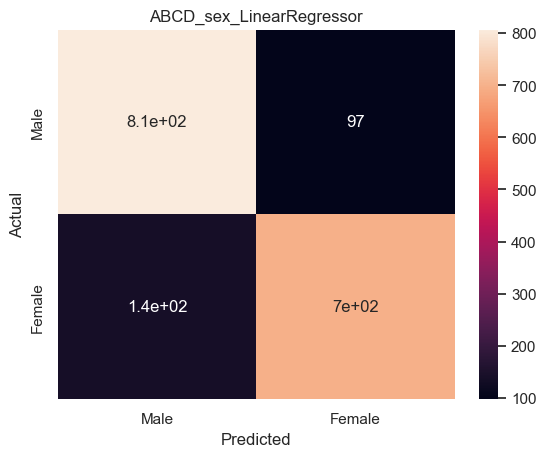

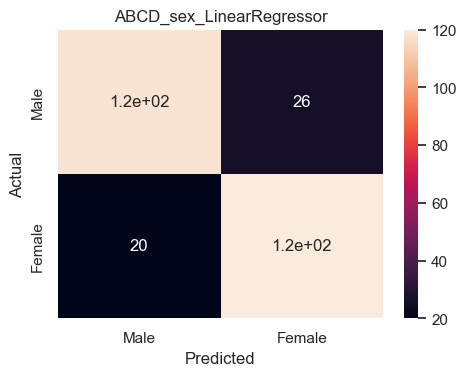

In [7]:
model = LinearRegressor(save_path=models_path, input_size=len(feature_cols)) #modfiy

model = model.to(device)
print(model)
train_model(model, device, config, experiment_title, dataloaders, verbose=True)
evaluate_regression(model, events_id_test, events_ood_test, config['target_col'], feature_cols, experiment_title=experiment_title, show_cm=True)

# MLP3 with custom

In [ ]:
#modify
exp_num = 0
experiment_title = 'ABCD_sex_MLPReg_' + str(exp_num) #for saving results
print(experiment_title)

config = {'target_col': 'kbi_sex_assigned_at_birth',
          'features': ['fmri', 'smri'],
          'model': ['abcd.models.regression.MLPRegressor', 'MLPRegressorCustom'],
          'lr': 1e-3,
          'batch_size': 64,
          'nr_epochs': 150,

          #added for experimentation
          'experiment_title': experiment_title,
          'num_layers': 3,
          'hidden_sizes': [256, 64]
        }

#leave unmodified
models_path = os.path.join(output_path, experiment_title, 'models')

In [ ]:
model = MLPRegressorCustom(save_path=models_path, input_size=len(feature_cols), num_layers=config['num_layers'], hidden_sizes=config['hidden_sizes']) #modfiy

model = model.to(device)
print(model)
train_model(model, device, config, experiment_title, dataloaders, verbose=False)
evals = evaluate_regression(model, events_id_test, events_ood_test, config['target_col'], feature_cols, experiment_title=experiment_title, show_cm=False)

# Find best model

In [8]:
hidden_sizes = [
    (128, 64),
    (256, 128, 64), 
    (512, 256, 128, 64),
    (1024, 512, 256, 128, 64),
]

learning_rates = [1e-3, 1e-5, 1e-7]

In [9]:
#IMPORTANT: change last_exp_num
last_exp_num = 0
experiments = {}

for i,learning_rate in enumerate(learning_rates):
    for j,sizes in enumerate(hidden_sizes):
        #define experiment parameters
        experiment_num = last_exp_num + i*len(hidden_sizes) + j
        print("experiment", experiment_num)
        experiment_title = 'ABCD_sex_MLPReg_' + str(experiment_num) #for saving results
        print(experiment_title, ": learning rate =", learning_rate, ", hidden sizes =", sizes)

        config = {'target_col': 'kbi_sex_assigned_at_birth',
                'features': ['fmri', 'smri'],
                'model': ['abcd.models.regression.MLPRegressor', 'MLPRegressorCustom'],
                'batch_size': 64,
                'nr_epochs': 500,
                }

        config['hidden_sizes'] = sizes
        config['num_layers'] = len(sizes) + 1
        config['lr'] = learning_rate

        #define and train model
        models_path = os.path.join(output_path, experiment_title, 'models')
        model = MLPRegressorCustom(save_path=models_path, input_size=len(feature_cols), num_layers=config['num_layers'], hidden_sizes=config['hidden_sizes'])
        model = model.to(device)
        train_model(model, device, config, experiment_title, dataloaders, verbose=False)

        #evaluate model
        evals = evaluate_regression(model, events_id_test, events_ood_test, config['target_col'], feature_cols, experiment_title=experiment_title, show_cm=False)
        print(evals, "\n")

        #save experiment
        experiments[experiment_title] = {'experiment_num': experiment_num, 'config': config, 'evals': evals}

experiment 0
ABCD_sex_MLPReg_0 : learning rate = 0.001 , hidden sizes = (128, 64)


100%|██████████| 150/150 [00:45<00:00,  3.30it/s]


Accuracy for Male class: 0.92
Accuracy for Female class: 0.80
Accuracy for Male class: 0.94
Accuracy for Female class: 0.76
{'mae_id': 0.19628565, 'mse_id': 0.1103402, 'male_acc_id': 0.9172056921086675, 'female_acc_id': 0.7979274611398963, 'cm_id': array([[709, 195],
       [ 64, 770]]), 'mae_ood': 0.22228779, 'mse_ood': 0.13385461, 'male_acc_ood': 0.9357798165137615, 'female_acc_ood': 0.76, 'cm_ood': array([[102,  42],
       [  7, 133]])} 

experiment 1
ABCD_sex_MLPReg_1 : learning rate = 0.001 , hidden sizes = (256, 128, 64)


100%|██████████| 150/150 [01:07<00:00,  2.23it/s]


Accuracy for Male class: 0.86
Accuracy for Female class: 0.85
Accuracy for Male class: 0.86
Accuracy for Female class: 0.81
{'mae_id': 0.17821096, 'mse_id': 0.10357069, 'male_acc_id': 0.8605927552140505, 'female_acc_id': 0.8548972188633616, 'cm_id': array([[784, 120],
       [127, 707]]), 'mae_ood': 0.19305934, 'mse_ood': 0.11169787, 'male_acc_ood': 0.8646616541353384, 'female_acc_ood': 0.8079470198675497, 'cm_ood': array([[115,  29],
       [ 18, 122]])} 

experiment 2
ABCD_sex_MLPReg_2 : learning rate = 0.001 , hidden sizes = (512, 256, 128, 64)


100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


Accuracy for Male class: 0.88
Accuracy for Female class: 0.84
Accuracy for Male class: 0.92
Accuracy for Female class: 0.77
{'mae_id': 0.21562906, 'mse_id': 0.101179734, 'male_acc_id': 0.8828932261768083, 'female_acc_id': 0.8442906574394463, 'cm_id': array([[769, 135],
       [102, 732]]), 'mae_ood': 0.23928812, 'mse_ood': 0.11823708, 'male_acc_ood': 0.9210526315789473, 'female_acc_ood': 0.7705882352941177, 'cm_ood': array([[105,  39],
       [  9, 131]])} 

experiment 3
ABCD_sex_MLPReg_3 : learning rate = 0.001 , hidden sizes = (1024, 512, 256, 128, 64)


100%|██████████| 150/150 [03:04<00:00,  1.23s/it]


Accuracy for Male class: 0.83
Accuracy for Female class: 0.89
Accuracy for Male class: 0.83
Accuracy for Female class: 0.85
{'mae_id': 0.18931459, 'mse_id': 0.10817008, 'male_acc_id': 0.8289738430583501, 'female_acc_id': 0.8924731182795699, 'cm_id': array([[824,  80],
       [170, 664]]), 'mae_ood': 0.20157844, 'mse_ood': 0.11100997, 'male_acc_ood': 0.8322147651006712, 'female_acc_ood': 0.8518518518518519, 'cm_ood': array([[124,  20],
       [ 25, 115]])} 

experiment 4
ABCD_sex_MLPReg_4 : learning rate = 1e-05 , hidden sizes = (128, 64)


100%|██████████| 150/150 [00:47<00:00,  3.18it/s]


Accuracy for Male class: 0.81
Accuracy for Female class: 0.83
Accuracy for Male class: 0.84
Accuracy for Female class: 0.79
{'mae_id': 0.30205873, 'mse_id': 0.13336843, 'male_acc_id': 0.8079748163693599, 'female_acc_id': 0.8292993630573249, 'cm_id': array([[770, 134],
       [183, 651]]), 'mae_ood': 0.31230828, 'mse_ood': 0.13537027, 'male_acc_ood': 0.835820895522388, 'female_acc_ood': 0.7866666666666666, 'cm_ood': array([[112,  32],
       [ 22, 118]])} 

experiment 5
ABCD_sex_MLPReg_5 : learning rate = 1e-05 , hidden sizes = (256, 128, 64)


100%|██████████| 150/150 [01:08<00:00,  2.18it/s]


Accuracy for Male class: 0.86
Accuracy for Female class: 0.83
Accuracy for Male class: 0.89
Accuracy for Female class: 0.77
{'mae_id': 0.25214586, 'mse_id': 0.11498807, 'male_acc_id': 0.8552188552188552, 'female_acc_id': 0.8323494687131051, 'cm_id': array([[762, 142],
       [129, 705]]), 'mae_ood': 0.2735093, 'mse_ood': 0.1259256, 'male_acc_ood': 0.8916666666666667, 'female_acc_ood': 0.774390243902439, 'cm_ood': array([[107,  37],
       [ 13, 127]])} 

experiment 6
ABCD_sex_MLPReg_6 : learning rate = 1e-05 , hidden sizes = (512, 256, 128, 64)


100%|██████████| 150/150 [01:52<00:00,  1.33it/s]


Accuracy for Male class: 0.87
Accuracy for Female class: 0.86
Accuracy for Male class: 0.86
Accuracy for Female class: 0.80
{'mae_id': 0.21406958, 'mse_id': 0.10527472, 'male_acc_id': 0.8683628318584071, 'female_acc_id': 0.8573141486810552, 'cm_id': array([[785, 119],
       [119, 715]]), 'mae_ood': 0.23501062, 'mse_ood': 0.11622472, 'male_acc_ood': 0.8571428571428571, 'female_acc_ood': 0.8013245033112583, 'cm_ood': array([[114,  30],
       [ 19, 121]])} 

experiment 7
ABCD_sex_MLPReg_7 : learning rate = 1e-05 , hidden sizes = (1024, 512, 256, 128, 64)


100%|██████████| 150/150 [03:07<00:00,  1.25s/it]


Accuracy for Male class: 0.87
Accuracy for Female class: 0.83
Accuracy for Male class: 0.87
Accuracy for Female class: 0.78
{'mae_id': 0.18921182, 'mse_id': 0.107275404, 'male_acc_id': 0.8729792147806005, 'female_acc_id': 0.8302752293577982, 'cm_id': array([[756, 148],
       [110, 724]]), 'mae_ood': 0.22310063, 'mse_ood': 0.12921062, 'male_acc_ood': 0.873015873015873, 'female_acc_ood': 0.7848101265822784, 'cm_ood': array([[110,  34],
       [ 16, 124]])} 

experiment 8
ABCD_sex_MLPReg_8 : learning rate = 1e-07 , hidden sizes = (128, 64)


100%|██████████| 150/150 [00:46<00:00,  3.25it/s]


Accuracy for Male class: 0.66
Accuracy for Female class: 0.73
Accuracy for Male class: 0.63
Accuracy for Female class: 0.77
{'mae_id': 0.47531164, 'mse_id': 0.2285499, 'male_acc_id': 0.6595174262734584, 'female_acc_id': 0.7318255250403877, 'cm_id': array([[738, 166],
       [381, 453]]), 'mae_ood': 0.47680497, 'mse_ood': 0.22953705, 'male_acc_ood': 0.634020618556701, 'female_acc_ood': 0.7666666666666667, 'cm_ood': array([[123,  21],
       [ 71,  69]])} 

experiment 9
ABCD_sex_MLPReg_9 : learning rate = 1e-07 , hidden sizes = (256, 128, 64)


100%|██████████| 150/150 [01:09<00:00,  2.17it/s]


Accuracy for Male class: 0.64
Accuracy for Female class: 0.66
Accuracy for Male class: 0.56
Accuracy for Female class: 0.84
{'mae_id': 0.47494453, 'mse_id': 0.22935955, 'male_acc_id': 0.6415458937198067, 'female_acc_id': 0.6586059743954481, 'cm_id': array([[664, 240],
       [371, 463]]), 'mae_ood': 0.48062128, 'mse_ood': 0.23508652, 'male_acc_ood': 0.5609756097560976, 'female_acc_ood': 0.8421052631578947, 'cm_ood': array([[138,   6],
       [108,  32]])} 

experiment 10
ABCD_sex_MLPReg_10 : learning rate = 1e-07 , hidden sizes = (512, 256, 128, 64)


100%|██████████| 150/150 [01:47<00:00,  1.39it/s]


Accuracy for Male class: 0.69
Accuracy for Female class: 0.73
Accuracy for Male class: 0.68
Accuracy for Female class: 0.82
{'mae_id': 0.45959663, 'mse_id': 0.21701917, 'male_acc_id': 0.6881616939364774, 'female_acc_id': 0.7296137339055794, 'cm_id': array([[715, 189],
       [324, 510]]), 'mae_ood': 0.46404433, 'mse_ood': 0.21928228, 'male_acc_ood': 0.6847826086956522, 'female_acc_ood': 0.82, 'cm_ood': array([[126,  18],
       [ 58,  82]])} 

experiment 11
ABCD_sex_MLPReg_11 : learning rate = 1e-07 , hidden sizes = (1024, 512, 256, 128, 64)


  6%|▌         | 9/150 [00:12<03:16,  1.39s/it]


KeyboardInterrupt: 

In [10]:
experiments

{'ABCD_sex_MLPReg_0': {'experiment_num': 0,
  'config': {'target_col': 'kbi_sex_assigned_at_birth',
   'features': ['fmri', 'smri'],
   'model': ['abcd.models.regression.MLPRegressor', 'MLPRegressorCustom'],
   'batch_size': 64,
   'nr_epochs': 150,
   'hidden_sizes': (128, 64),
   'num_layers': 3,
   'lr': 0.001},
  'evals': {'mae_id': 0.19628565,
   'mse_id': 0.1103402,
   'male_acc_id': 0.9172056921086675,
   'female_acc_id': 0.7979274611398963,
   'cm_id': array([[709, 195],
          [ 64, 770]]),
   'mae_ood': 0.22228779,
   'mse_ood': 0.13385461,
   'male_acc_ood': 0.9357798165137615,
   'female_acc_ood': 0.76,
   'cm_ood': array([[102,  42],
          [  7, 133]])}},
 'ABCD_sex_MLPReg_1': {'experiment_num': 1,
  'config': {'target_col': 'kbi_sex_assigned_at_birth',
   'features': ['fmri', 'smri'],
   'model': ['abcd.models.regression.MLPRegressor', 'MLPRegressorCustom'],
   'batch_size': 64,
   'nr_epochs': 150,
   'hidden_sizes': (256, 128, 64),
   'num_layers': 4,
   'lr': 0.